# Определение порядка водотоков

Для подготовки данных были произведены следующие действия:
* Перевод слоя полигональных объектов в линейные: ВЕКТОР - ОБРАБОТКА ГЕОМЕТРИИ - ПРЕОБРАЗОВАТЬ ПОЛИГОНЫ В ЛИНИИ (QGIS)
* Объединение линейных векторных слоев: ВЕКТОР - ГЕООБРАБОТКА - ОБЪЕДИНЕНИЕ (QGIS)
* Разбиение линий на сегменты: АНАЛИЗ - ВЕКТОРНЫЙ ОВЕРЛЕЙ - РАЗБИТЬ ЛИНИЯМИ (QGIS)
* Задание новых полей с индексами: PYTHON
* Извлечение вершин на пересечениях сегментов: ВЕКТОР - АНАЛИЗ - ПЕРЕСЕЧЕНИЯ ЛИНИЙ (QGIS)

В результате преобразований был получен следующий векторный слой: v_new.shp

In [2]:
# Загрузим все нужные библиотеки 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
import time
import networkx as nx
import geopandas

## Загрузка векторного слоя 

In [2]:
data = geopandas.read_file('/media/mikhail/Data/Ob/Simple_example/v_new.shp')
data.head(5)

,id,NEW,id_2,NEW_2,geometry
0,1,1,1,2,POINT (30.99791 59.93690)
1,1,1,2,5,POINT (30.99791 59.93690)
2,1,2,1,1,POINT (30.99791 59.93690)
3,1,2,1,3,POINT (30.75824 59.76402)
4,1,2,2,5,POINT (30.99791 59.93689)


## Формирование графа

На данном этапе данные можно описать следующим образом. Точки находятся на пересечениях сегментов. Все сегменты рек проиндексированы в поле NEW, все реки (которые состоят из нескольких сегментов) проиндексированы с помощью значений поля id. В результате определения точек пересечния сегментов, таблица атрибутов была преобразована. Были сформированы поля id_2 и NEW_2 - то есть точка характеризуется двуям парами полей: "id" и "NEW". Рассмотрим пару полей NEW и NEW_2, так как в дальнейшем будем использовать именно их. Каждая строка - это точка пересчения сегментов, в таком случае сегмент реки NEW через данную точку имеет пересечение с NEW_2. 

Таким образом, если рассматривать сегменты реки как вершины, а их связи/пересечения как ребра, то таблицу, составленную из полей NEW и NEW2 можно воспринимать как список смежности.

In [3]:
list_of_adjacencies = data[['NEW', 'NEW_2']]
list_of_adjacencies = np.array(list_of_adjacencies)

# Функция для приведения списка смежности к нужному формату
def prepare(list_of_adjacencies):
    lines = []
    for i in list_of_adjacencies:
        i_0 = str(i[0])
        i_1 = str(i[1])
        string = i_0 + ' ' + i_1
        lines.append(string)
    return(lines)

lines = prepare(list_of_adjacencies)
G = nx.parse_adjlist(lines, nodetype = int)
print('Было: \n', list_of_adjacencies[0:2], '\n')
print('Стало: \n', lines[0:2], '\n')
# Посмотрим, корректно ли мы опередили граф
print('Список всех вершин (сегментов реки):', G.nodes())

Было: 
 [[1 2]
 [1 5]] 

Стало: 
 ['1 2', '1 5'] 

Список всех вершин (сегментов реки): [1, 2, 5, 3, 6, 4, 7]


Визуализируем граф

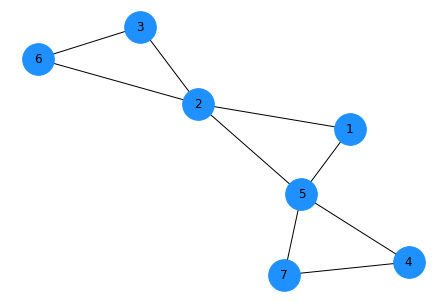

In [4]:
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, node_color='#1E90FF', node_size=1000) 

Стоит обратить внимание, что граф, составленный по гидрологической сети таким образом содержит много циклов.

Основные этапы обработки можно описать в виде схемы:
![Flow.png](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/flow.png)

Первые этапы выполнялись над векторным слоем водотоков в геоинформационной системе QGIS. Алгоритм обхода графа осуществлялся с помощью скриптов на Python.

## Алгоритм присваивания вершинам (сегментам реки) их порядка в речной сети

Мы предполагаем, что нам известно, какой сегмент в речной сети является замыкающим (устье реки). Поэтому присваивание атрибутов будет происходить, начниая именно с него. В данном примере номер сегмена, с которого мы будем начинать обход графа - 1.

Код ниже присваивает замыкающему сегменту ранг 1, всем сегментам, впадающим в замыкающий - ранг 2, все сегменты, впадающие в притоки второго ранга - ранг 3 и т.д.

### 1. Присваивание ранга кажому сегменту (атрибут 'rank')

In [5]:
# Количество вершин в графе
nodes_amount = len(G.nodes())
print('Количество вершин в графе -', nodes_amount)

# Функция для присваивания атрибутов вершинам графа
def attr_set(G, start):
    # Начальной вершине присвоим значением атрибута - 1
    attrs = {start: {'rank' : 1}}
    nx.set_node_attributes(G, attrs)
    
    # Список со всеми вершинами, до которых можно добраться из точки start
    # при помощи поиска в ширину
    vert_list = list(nx.bfs_successors(G, source = start)) 

    # Цикл обхода графа с присваиванием меток вершинам
    # Каждая компонента - это небольшой подграф
    for component in vert_list:
        vertex = component[0] # Вершина в которой находимся на данной итерации
        neighbors = component[1] # Вершины, которые являются соседними (которые мы еще не посещали)
        
        # Добавление атрибута - количество потомков у данной вершины
        n_offspring = len(neighbors)
        attrs = {vertex: {'offspring' : n_offspring}}
        nx.set_node_attributes(G, attrs)
        
        # Значение атрибута в рассматриваемой вершине
        att = G.nodes[vertex].get('rank')
        if att != None:
            # Значение атрибута, которое будет присвоено соседним вершинам
            att_number = att + 1
        
        # Для каждого соседа производим присваивание атрибута
        for i in neighbors:
            attrs = {i: {'rank' : att_number}}
            nx.set_node_attributes(G, attrs)
    
    # Проверка, правильно ли мы все сделали
    for vertex in list(G.nodes()):
        # Если граф неполносвязный, то удаляем те элементы, до которых мы не можем добраться
        if G.nodes[vertex].get('rank') == None:
            G.remove_node(vertex)
        else:
            print(vertex, ' - ', G.nodes[vertex])

attr_set(G, 1)

Количество вершин в графе - 7
1  -  {'rank': 1, 'offspring': 2}
2  -  {'rank': 2, 'offspring': 2}
5  -  {'rank': 2, 'offspring': 2}
3  -  {'rank': 3}
6  -  {'rank': 3}
4  -  {'rank': 3}
7  -  {'rank': 3}


## Основной алгоритм - присваивание порядка водотоков 

Всем вершинам, у которых нет потомков, присваивается значение 1. Всем вершинам, которые имеют в качестве потомков вершины с 1 - присваивается значение равное количеству потомков с этими единицами.

### 2. Определение порядка водотоков (атрибут 'value')

In [6]:
# Функция для определения порядка сегментов реки по аналогии с методом Шреве
def set_values(G, start):    
    # Список со всеми вершинами, до которых можно добраться из точки start
    # при помощи поиска в ширину
    vert_list = list(nx.bfs_successors(G, source = start)) 

    # Цикл обхода графа с присваиванием меток вершинам
    # Каждая компонента - это небольшой подграф
    for component in vert_list:
        vertex = component[0] # Вершина в которой находимся на данной итерации
        neighbors = component[1] # Вершины, которые являются соседними (которые мы еще не посещали)
        
        att_rank = G.nodes[vertex].get('rank')
        att_offspring = G.nodes[vertex].get('offspring')
        
        # Для замыкающего сегмента производим следующую процедуру:
        if att_rank == 1:
            # Определяем потомков
            offspring = list(nx.bfs_successors(G, source = vertex, depth_limit = 1)) 
            # Используем только ближайших к данной вершине соседей (прямых потомков)
            offspring = offspring[0][1]
            
            # Записываем в список значения атрибутов value у всех потомков
            last_values = []
            for child in offspring:
                if G.nodes[child].get('value') != None:
                    last_values.append(G.nodes[child].get('value'))
                else:
                    last_values.append(0)
                    
            last_values = np.array(last_values)
            sum_values = np.sum(last_values)
            
            # Если сумма не равна 0, то атрибут присваивается
            if sum_values != 0:
                attrs = {vertex: {'value' : sum_values}}
                nx.set_node_attributes(G, attrs)
            # Иначе алгоритм просто еще не дошел, пропускаем этот пункт
            else:
                pass
            
        # Для каждого соседа производим присваивание атрибута
        for i in neighbors:
            # Значение атрибутов в рассматриваемой вершине
            att_rank = G.nodes[i].get('rank')
            att_offspring = G.nodes[i].get('offspring')
            
            # Если у вершины на предыдущем этапе не было найдено потомков, то ей присваивается значение 1
            if att_offspring == None:
                attrs = {i: {'value' : 1}}
                nx.set_node_attributes(G, attrs)            
            # Если вершина имеет потомков, то необходимо определить значения атрибута "value" в них
            else:
                # Производим поиск всех потомков
                offspring = list(nx.bfs_successors(G, source = i, depth_limit = 1)) 
                # Используем только ближайших к данной вершине соседей (прямых потомков)
                offspring = offspring[0][1]

                # Цикл определения значений в вершинах - потомках
                last_values = []
                for child in offspring:
                    # Нужны только те потомки, значение ранга которых строго больше, чем у рассматриваемой вершины
                    if G.nodes[child].get('rank') > att_rank:
                        if G.nodes[child].get('value') != None:
                            last_values.append(G.nodes[child].get('value'))
                        else:
                            pass
                    else:
                        pass
                    
                last_values = np.array(last_values)
                sum_values = np.sum(last_values)
                
                # Если сумма не равна 0, то атрибут присваивается
                if sum_values != 0:
                    attrs = {i: {'value' : sum_values}}
                    nx.set_node_attributes(G, attrs)
                # Иначе алгоритм просто еще не дошел, пропускаем этот пункт
                else:
                    pass          
                
    # Проверка, правильно ли мы все сделали
    for vertex in list(G.nodes()):
        print(vertex, ' - ', G.nodes[vertex])
    print('\n')

# Поскольку мы начинаем обход графа из стартовой точки, то нам необходимо производить несколько итераций последовательно
# Функция для итеративного обхода
def iter_sets(G, start):
    # Определяем максимальное значение ранга в данном графе
    ranks = []
    for vertex in list(G.nodes()):
        ranks.append(G.nodes[vertex].get('rank'))
    max_rank = max(ranks) 
    
    # Мы должны проитерировать ровно столько раз, сколько рангов есть в графе
    for iteration in range(0, max_rank):
        set_values(G, start)

# Применение алгоритма: запускаем функцию iter_sets
iter_sets(G, 1)

1  -  {'rank': 1, 'offspring': 2}
2  -  {'rank': 2, 'offspring': 2}
5  -  {'rank': 2, 'offspring': 2}
3  -  {'rank': 3, 'value': 1}
6  -  {'rank': 3, 'value': 1}
4  -  {'rank': 3, 'value': 1}
7  -  {'rank': 3, 'value': 1}


1  -  {'rank': 1, 'offspring': 2}
2  -  {'rank': 2, 'offspring': 2, 'value': 2}
5  -  {'rank': 2, 'offspring': 2, 'value': 2}
3  -  {'rank': 3, 'value': 1}
6  -  {'rank': 3, 'value': 1}
4  -  {'rank': 3, 'value': 1}
7  -  {'rank': 3, 'value': 1}


1  -  {'rank': 1, 'offspring': 2, 'value': 4}
2  -  {'rank': 2, 'offspring': 2, 'value': 2}
5  -  {'rank': 2, 'offspring': 2, 'value': 2}
3  -  {'rank': 3, 'value': 1}
6  -  {'rank': 3, 'value': 1}
4  -  {'rank': 3, 'value': 1}
7  -  {'rank': 3, 'value': 1}




Таким образом обход графа производится в 2 этапа:

1) Присваивание вершинам графа атрибута 'rank', где значение ранга равно 1 для замыкающего сегмента, 2 - для всех его притоков, 3 - для всех притоков 2го ранга и т.д. Также вершинам присваивается атрибут 'offspring' - количество прямых потомков у данной вершины (значение ранга потомков всегда на 1 больше, чем у рассматриваемой вершины)

2) Присваивание вершинам графа атрибута 'value' на основе количества потомков у вершин и их ранга. При этом, отсутствие прямых потомков у вершины свидетельствует о том, что данный сегмент не имеет притоков и должен получить значение 'value' - 1. 

Визуализация процесса работы алгоритма:

![animation_graph.gif](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/animation_graph.gif)

## Заполнение атрибутивной таблицы для векторного слоя

Мы построили и обошли граф, теперь необходимо сохранить результаты.

In [7]:
# Составляем датасет, где каждая вершина - строка
def make_dataframe(G):    
    dataframe = []
    for vertex in list(G.nodes()):
        rank = G.nodes[vertex].get('rank')
        value = G.nodes[vertex].get('value')
        dataframe.append([vertex, rank, value])

    dataframe = pd.DataFrame(dataframe, columns = ['NEW', 'Rank', 'Value'])
    return(dataframe)
    
dataframe = make_dataframe(G)

In [8]:
# Загружаем исходный слой с реками
rivers = geopandas.read_file('/media/mikhail/Data/Ob/Simple_example/r_new.shp')

# Объединяем датасеты
data_merged = pd.merge(rivers, dataframe, on = 'NEW')
# Сохраняем в файл
data_merged.to_file("/media/mikhail/Data/Ob/Simple_example/r_new_with_att.shp")

data_merged

,id,NEW,geometry,Rank,Value
0,1,1,"LINESTRING (31.03324 59.95152, 30.99833 59.937...",1,4
1,1,2,"LINESTRING (30.99791 59.93690, 30.98531 59.916...",2,2
2,1,3,"LINESTRING (30.75824 59.76402, 30.74834 59.770...",3,1
3,2,4,"LINESTRING (30.85074 59.95570, 30.85673 59.95648)",3,1
4,2,5,"LINESTRING (30.85667 59.95647, 30.85667 59.956...",2,2
5,3,6,"LINESTRING (30.75755 59.73085, 30.75700 59.732...",3,1
6,4,7,"LINESTRING (30.86031 59.96864, 30.86025 59.968...",3,1


## Новый подход к ранжированию водотоков

При тестировании данного алгоритма на некоторых речных сетях выснилось несколько важных моментов:

1) В районе дельты реки могут очень сильно ветвиться. Одни рукава отходят и впадают в конечный водоем раньше главной реки, другие - петляя, снова впадают в главную реку. Это приводило к конфликтам на этапе присваивания рангов. То есть сегмент с рангом 5 мог быть соединен с сегментом с рангом 8. В рамках исходного подхода данный конфликт решить не удалось.

2) Не имелось возможности использовать данный алгоритм в виде встраиваемого решения в единой цепи обработки. Проблема заключалась в том, что, при ранжировании рек, алгоритм, естественно, не подозревал, какая река в сети является главной. Поскольку определить это однозначно для сильно разветвленных рек (дельта расходится на множество рукавов) не удавалось, то после работы алгоритма необходимо было привлекать эксперта, который бы вручную исправлял все неточности. Применять, таким образом, алгоритм можно было только в полуавтоматическом режиме.

Пример конфликта, который мог возникнуть при использовании алгоритма:

![animation_graph_2.gif](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/animation_graph_2.gif)

#### Предложенное решение

Загружаем нужные библиотеки и shp файл, в таблице атрибутов которого уже содержится информация о протяженностях участков маршрутов. 

In [2]:
# Загрузим все нужные библиотеки 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
import time
import networkx as nx
import geopandas
import timeit

from pylab import rcParams
rcParams['figure.figsize'] = 11, 7

l_data = geopandas.read_file('/media/mikhail/Data1/Ob/URAL_test/Attrubute_main2.shp')
# Составляем датафрейм, где присутствуют данные об идентификаторах и длинах сегментов рек
dataframe = pd.DataFrame(l_data[['length', 'id']])
dataframe = dataframe.astype({'id': 'str'})
# Загружаем данные с разделенными по пересечениям
data = geopandas.read_file('/media/mikhail/Data1/Ob/URAL_test/Attrubute_main2_points.shp')

# Переименовываем 
data = data.rename(columns={"NEW_ID": "id", "NEW_ID_2": "id_2"})

Подготавливаем граф как объект для библиотеки networkx.

In [37]:
list_of_adjacencies = data[['id', 'id_2']]
list_of_adjacencies = np.array(list_of_adjacencies)

# Function for bringing the adjacency list to the right format
def prepare(list_of_adjacencies):
    lines = []
    for i in list_of_adjacencies:
        i_0 = str(i[0])
        i_1 = str(i[1])
        
        # Block for checking spaces in a line
        # Left part
        triger = ' ' in i_0
        if triger == True:
            i_0 = i_0.replace(' ', '_')
            
        # Right part
        triger = ' ' in i_1
        if triger == True:
            i_1 = i_1.replace(' ', '_')
        
        string = i_0 + ' ' + i_1
        lines.append(string)
    return(lines)

lines = prepare(list_of_adjacencies)
G = nx.parse_adjlist(lines, nodetype = str)
print('Было: \n', list_of_adjacencies[0:2], '\n')
print('Стало: \n', lines[0:2], '\n')
# Let's see if we got ahead of the graph correctly
print('Список всех вершин (сегментов реки):', G.nodes())

Было: 
 [['140.0:0' '7150.0:1']
 ['140.0:0' '7726.0:0']] 

Стало: 
 ['140.0:0 7150.0:1', '140.0:0 7726.0:0'] 

Список всех вершин (сегментов реки): ['140.0:0', '7150.0:1', '7726.0:0', '-9999:58', '160.0:0', '1950.0:0', '9213.0:0', '-9999:60', '180.0:0', '240.0:2', '6584.0:0', '-9999:64', '-9999:83', '240.0:0', '240.0:1', '-9999:61', '6575.0:0', '-9999:62', '240.0:6', '-9999:74', '240.0:3', '240.0:4', '5282.0:0', '10321.0:0', '-9999:63', '-9999:67', '-9999:94', '240.0:5', '6577.0:0', '6589.0:0', '-9999:66', '318.0:0', '-9999:54', '-9999:68', '-9999:69', '428.0:0', '5278.0:0', '-9999:12', '-9999:13', '-9999:71', '448.0:0', '1953.0:0', '7137.0:3', '9505.0:1', '556.0:0', '1280.0:0', '-9999:38', '-9999:88', '-9999:152', '726.0:0', '7680.0:0', '7707.0:1', '-9999:76', '-9999:78', '726.0:1', '726.0:2', '6592.0:0', '9208.0:0', '6585.0:1', '-9999:77', '726.0:3', '7678.0:0', '9996.0:0', '12334.0:0', '726.0:4', '6583.0:0', '12476.0:1', '-9999:75', '897.0:0', '897.0:2', '9737.0:0', '897.0:1', '1944

Визуализируем получившийся граф

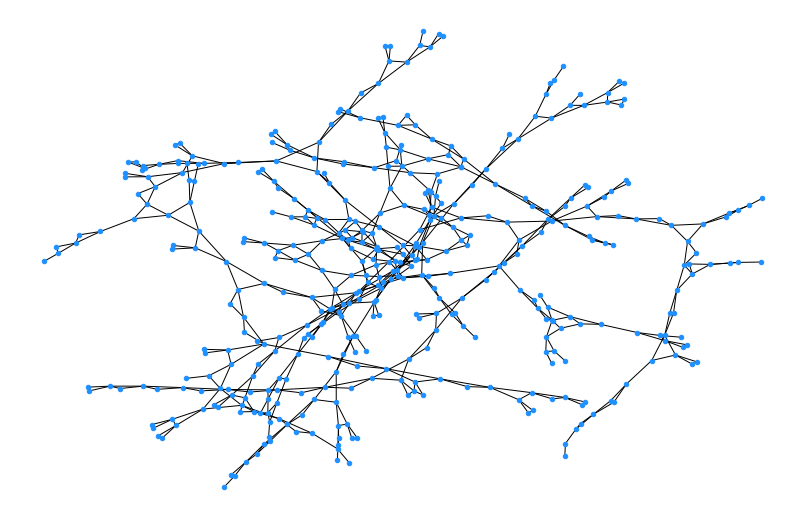

In [4]:
nx.draw(G,pos=nx.spring_layout(G), with_labels=False, node_color='#1E90FF', node_size=20) 

### Функция distance_attr
Задача: Присваивание весов ребрам графа
Также для каждой вершины присваивается значение атрибута 'size', которое означаяет протяженность сегмента реки.

Input:
* G --- исходный граф
* start --- вершина, из которой требуется начинать обход
* dataframe --- pandas датафрейм, в котором присутствуют 2 столбца: id_field (идентификатор сегмента/вершины) и 'length' (длина данного сегмента)
* id_field --- поле в dataframe, из которого требуется сопоставлять идентификаторы с вершинами графа
* main_id --- индекс, которым обозначается главная река в речной сети (по умолчанию = None)

Output:
* На исходном графе ребрам присваиваются веса таким образом, что если начальная вершина 1, соседние с ней узлы графа: 2 и 3, где значение атрибута 'length' для сегментов 1 - 10, 2 - 15, 3 - 20. В результате ребрам будет присвоены значения следующим образом: (1, 2) и (2, 1) - 15; (1, 3) и (3, 1) - 20 и т.д.
* last_vertex --- одна из самых удаленных вершин от начальной в графе (даная вершина необхоима для нахождения кратчайшег пути между двумя самыми удаленными сегментами в речной сети)

> В рамках данной функции осуществляется также выделение одной компоненты связности в графе. Все вершины, которые не входят в данный подграф, удаляются

In [5]:
# Function for assigning weights to graph edges
def distance_attr(G, start, dataframe, id_field, main_id = None):
      
    # List of all vertexes that can be reached from the start vertex using BFS
    vert_list = list(nx.bfs_successors(G, source=start))
    # One of the most remote vertices in the graph (this will be necessary for A*)
    last_vertex = vert_list[-1][-1][0]
    
    for component in vert_list:
        vertex = component[0]  # The vertex where we are at this iteration
        neighbors = component[1]  # Vertices that are neighboring (which we haven't visited yet)
        
        dist_vertex = int(dataframe['length'][dataframe[id_field] == vertex])
        # Assign the segment length value as a vertex attribute
        attrs = {vertex: {'component' : 1, 'size' : dist_vertex}}
        nx.set_node_attributes(G, attrs)
        
        for n in neighbors:  
            
            # If the main index value is not set
            if main_id == None:
                # Assign weights to the edges of the graph
                # The length of the section in meters (int)
                dist_n = int(dataframe['length'][dataframe[id_field] == n])   
            # Otherwise we are dealing with a complex composite index
            else:
                # If the vertex we are at is part of the main river
                if vertex.split(':')[0] == main_id:
                    # And at the same time, the vertex that we "look" at from the vertex "vertex" also, then
                    if n.split(':')[0] == main_id:
                        # The weight value must be zero
                        dist_n = 0
                    else:
                        dist_n = int(dataframe['length'][dataframe[id_field] == n])
                else:
                    dist_n = int(dataframe['length'][dataframe[id_field] == n])
            attrs = {(vertex, n): {'weight': dist_n},
                     (n, vertex): {'weight': dist_n}}
            nx.set_edge_attributes(G, attrs)    
            
            # Assign attributes to the nodes of the graph
            attrs = {n: {'component' : 1, 'size' : dist_n}}
            nx.set_node_attributes(G, attrs)
            
        
        # Look at the surroundings of the vertex where we are located
        offspring = list(nx.bfs_successors(G, source = vertex, depth_limit = 1)) 
        offspring = offspring[0][1]
        # If the weight value was not assigned, we assign it
        for n in offspring:
            
            if len(G.get_edge_data(vertex, n)) == 0:
                
                ##############################
                # Assigning weights to edges #
                ##############################
                if main_id == None:
                    dist_n = int(dataframe['length'][dataframe[id_field] == n])   
                else:
                    if vertex.split(':')[0] == main_id:
                        if n.split(':')[0] == main_id:
                            dist_n = 0
                        else:
                            dist_n = int(dataframe['length'][dataframe[id_field] == n])
                    else:
                        dist_n = int(dataframe['length'][dataframe[id_field] == n])
                attrs = {(vertex, n): {'weight': dist_n},
                         (n, vertex): {'weight': dist_n}}
                nx.set_edge_attributes(G, attrs)
                ##############################
                # Assigning weights to edges #
                ##############################
                
            elif len(G.get_edge_data(n, vertex)) == 0:
                
                ##############################
                # Assigning weights to edges #
                ##############################
                if main_id == None:
                    dist_n = int(dataframe['length'][dataframe[id_field] == n])   
                else:
                    if vertex.split(':')[0] == main_id:
                        if n.split(':')[0] == main_id:
                            dist_n = 0
                        else:
                            dist_n = int(dataframe['length'][dataframe[id_field] == n])
                    else:
                        dist_n = int(dataframe['length'][dataframe[id_field] == n])
                attrs = {(vertex, n): {'weight': dist_n},
                         (n, vertex): {'weight': dist_n}}
                nx.set_edge_attributes(G, attrs)    
                ##############################
                # Assigning weights to edges #
                ##############################
        
    for vertex in list(G.nodes()):
        # If the graph is incompletely connected, then we delete the elements that we can't get to
        if G.nodes[vertex].get('component') == None:
            G.remove_node(vertex)
        else:
            pass    
    return(last_vertex)    

# The application of the algorithm
last_vertex = distance_attr(G, '7126.0:23', dataframe, id_field = 'id', main_id = '7126.0')

### Функция rank_set
Задача: Присваивание атрибутов 'rank' и 'offspring' вершинам графа

Input:
* G --- граф с присвоенными весами на ребрах
* start --- вершина, из которой требуется начинать обход
* last_vertex --- одна из самых удаленных вершин от начальной в графе

Output:
* Каждой вершине графа присваивается значение его ранга в речной сети. Ранг 1 имеет сегмент реки, который является замыкающим в речной сети. Ранг 2 имеют притоки, которые впадают в сегмент ранга 1. Ранг 3 имеют притоки, которые впадают в сегмент ранга 2 и т.д. После того, как все вершины графа имеют значение атрибута 'rank', производится подсчет потомков для каждой вершины 'offspring'. Значение атрибута 'offspring' можно интерпретировать как 'количество сегментов, которое впадает в данный сегмент речной сети'. 

Подробное описание:
Между двумя вершинами (start и last_vertex) на взвешенном графе G с помощью алгоритма A* ищется маршрут с наименьшей длиной. После, проверяется корректность построенного маршрута и осушествляется его модификация, если выясняется, что построенный маршрут не оптимален (из-за неточностей в исходном векторном слое).  

Полученный маршрут будет являться опорным, играть роль совеобразного "якоря", который будет удерживать алгоритм от включения возмущений в конечный результат. Всем вершинам опорного маршрута присваивается значение атрибута rank от 1 до максимально возможного значения в данной речной сети.

Затем, каждая опорная вершина изолируется от других опорных. После чего запускается поиск в ширину по полученному подграфу с присваиванием атрибута 'rank' вершинам. Важно: подграф также изолируется от других опорных вершин.

Схема обхода графа описанным образом представлена ниже:

![animation_graph_3.gif](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/animation_graph_3.gif)

In [6]:
# Function for assigning 'rank' and 'offspring' attributes to graph vertices
def rank_set(G, start, last_vertex):
    
    # Traversing a graph with attribute assignment
    # G           --- graph as a networkx object
    # vertex      --- vertex from which the graph search begins
    # kernel_path --- list of vertexes that are part of the main path that the search is being built from
    def bfs_attributes(G, vertex, kernel_path):
        
        # Creating a copy of the graph
        G_copy = G.copy()
        
        # Deleting all edges that are associated with the reference vertexes
        for kernel_vertex in kernel_path:
            # Leaving the reference vertex from which we start the crawl
            if kernel_vertex == vertex:
                pass
            else:
                # For all other vertexes, we delete edges
                kernel_n = list(nx.bfs_successors(G_copy, source = kernel_vertex, depth_limit = 1))   
                kernel_n = kernel_n[0][1]
                for i in kernel_n:
                    try:
                        G_copy.remove_edge(i, kernel_vertex)
                    except Exception:
                        pass
                    
        # The obtained subgraph is isolated from all reference vertices, except the one 
        # from which the search begins at this iteration                   
        # Breadth-first search
        all_neighbors = list(nx.bfs_successors(G_copy, source = vertex))    
        
        ############################################################################
        #                               Attention!                                 #
        # Labels are not assigned on an isolated subgraph, but on the source graph #
        ############################################################################
        for component in all_neighbors:
            v = component[0] # The vertex where we are at this iteration
            neighbors = component[1] # Vertices that are neighboring (which we haven't visited yet)
            
            # Value of the 'rank' attribute in the considering vertex
            att = G.nodes[v].get('rank')
            if att != None:
                # The value of the attribute to be assigned to neighboring vertices
                att_number = att + 1

            # We look at all the closest first offspring
            first_n = list(nx.bfs_successors(G, source = v, depth_limit = 1))   
            first_n = first_n[0][1]

            # Assigning ranks to vertices
            for i in first_n: 
                # If the neighboring vertex is the main node in this iteration, then skip it
                # vertex - the reference point from which we started the search
                if i == vertex:
                    pass 
                else:
                    current_i_rank = G.nodes[i].get('rank')
                    # If the rank value has not yet been assigned, then assign it
                    if current_i_rank == None:
                        attrs = {i: {'rank': att_number}}
                        nx.set_node_attributes(G, attrs)
                    # If the rank in this node is already assigned
                    else:
                        # The algorithm either "looks back" at vertices that it has already visited
                        # In this case we don't do anything
                        # Either the algorithm "came up" to the main path (kernel path) in the graph
                        if any(i == bearing_v for bearing_v in kernel_path):
                            G.remove_edge(v, i)
                        else:
                            pass
            
            # Additional "search"
            for neighbor in neighbors:
                # We look at all the closest first offspring
                first_n = list(nx.bfs_successors(G, source = neighbor, depth_limit = 1))   
                first_n = first_n[0][1]

                for i in first_n: 
                    # If the neighboring vertex is the main node in this iteration, then skip it
                    # vertex - the reference point from which we started the search
                    if i == vertex:
                        pass 
                    else:
                        # The algorithm either "looks back" at vertices that it has already visited
                        # In this case we don't do anything
                        # Either the algorithm "came up" to the main path (kernel path) in the graph
                        if any(i == bearing_v for bearing_v in kernel_path):
                            G.remove_edge(neighbor, i)
                        else:
                            pass               
    
    # Finding the shortest path A* - building a route around which we will build the next searchs
    a_path = list(nx.astar_path(G, source = start, target = last_vertex, weight = 'weight'))

    ##############################
    #   Route validation block   #
    ##############################
    true_a_path = []
    for index, V in enumerate(a_path):
        if index == 0:
            true_a_path.append(V)
        elif index == (len(a_path) - 1):
            true_a_path.append(V)
        else:
            # Previous and next vertices for the reference path (a_path)
            V_prev = a_path[index - 1]
            V_next = a_path[index + 1]
            
            # Which vertexes are adjacent to this one
            V_prev_neighborhood = list(nx.bfs_successors(G, source = V_prev, depth_limit = 1)) 
            V_prev_neighborhood = V_prev_neighborhood[0][1]
            V_next_neighborhood = list(nx.bfs_successors(G, source = V_next, depth_limit = 1))
            V_next_neighborhood = V_next_neighborhood[0][1]
            
            # If the next and previous vertices are connected to each other without an intermediary
            # in the form of vertex V, then vertex V is excluded from the reference path
            if any(V_next == VPREV for VPREV in V_prev_neighborhood):
                if any(V_prev == VNEXT for VNEXT in V_next_neighborhood):
                    pass
                else:
                    true_a_path.append(V)
            else:
                true_a_path.append(V)
    ##############################
    #   Route validation block   #
    ##############################
    
    # Verification completed
    a_path = true_a_path     
    RANK = 1
    for v in a_path:
        # Assign the attribute rank value - 1 to the starting vertex. The further away, the greater the value
        attrs = {v: {'rank' : RANK}}
        nx.set_node_attributes(G, attrs) 
        RANK += 1
    
    # The main route is ready, then we will iteratively move from each node
    for index, vertex in enumerate(a_path):
        # Starting vertex
        if index == 0:
            next_vertex = a_path[index + 1]
            
            # Disconnect vertices
            G.remove_edge(vertex, next_vertex)
            
            # Subgraph BFS block
            bfs_attributes(G, vertex = vertex, kernel_path = a_path)      
            
            # Connect vertices back
            G.add_edge(vertex, next_vertex)

    
        # Finishing vertex
        elif index == (len(a_path) - 1):
            prev_vertex = a_path[index - 1]
            
            # Disconnect vertices
            G.remove_edge(prev_vertex, vertex)
            
            # Subgraph BFS block
            bfs_attributes(G, vertex = vertex, kernel_path = a_path)
            
            # Connect vertices back
            G.add_edge(prev_vertex, vertex)
            
        # Vertices that are not the first or last in the reference path
        else:
            prev_vertex = a_path[index - 1]
            next_vertex = a_path[index + 1]
            
            # Disconnect vertices 
            # Previous with current vertex
            try:
                G.remove_edge(prev_vertex, vertex)
            except Exception:
                pass
            # Current with next vertex
            try:
                G.remove_edge(vertex, next_vertex)
            except Exception:
                pass
            
            # Subgraph BFS block
            bfs_attributes(G, vertex = vertex, kernel_path = a_path)
            
            # Connect vertices back
            try:
                G.add_edge(prev_vertex, vertex)
                G.add_edge(vertex, next_vertex)
            except Exception:
                pass
    
    # Attribute assignment block - number of descendants 
    vert_list = list(nx.bfs_successors(G, source = start)) 
    for component in vert_list:
        vertex = component[0] # The vertex where we are at this iteration
        neighbors = component[1] # Vertices that are neighboring (which we haven't visited yet)
        
        # Adding an attribute - the number of descendants of this vertex
        n_offspring = len(neighbors)
        attrs = {vertex: {'offspring' : n_offspring}}
        nx.set_node_attributes(G, attrs)


start = timeit.default_timer()  # Засекаем время
rank_set(G, '7126.0:23', last_vertex)
print('Runtime -', timeit.default_timer() - start, '\n') 

Runtime - 0.17917526300016107 



### Функция iter_set_values
Задача: Присваивание вршинам графа атрибута 'value'.
Также присвиавается вершинам графа атрибут 'distance' как мера удаленности сегмента от устья реки. 

Input:
* G --- граф с присвоенными значениями атрибутов 'rank' и 'offspring'
* start --- вершина, из которой требуется начинать обход

Output:
* Каждой вершине графа G присваивается значение атрибута 'value'. Значение данного атрибута можно интерпретировать как 'количество совокупно впадающих притоков в данную часть речной сети'.

Подробное описание: Алгоритм вызывает функцию set_values ровно столько раз, сколько рангов было обнаружено в рассматриваемой речной сети. Алгоритм сначала присваивает значение 'value' = 1 тем вершинам, у которых нет впадающих в них сегментов (значение атрибута 'offspring' равно None), а затем последовательно приближается к начальной вершине.

Демонстрация работы алгоритма:

![animation_graph_4.gif](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/animation_graph_4.gif)

In [7]:
# Function for determining the order of river segments similar to the Shreve method
# In addition, the "distance" attribute is assigned
def set_values(G, start, considering_rank, vert_list): 
    
    # For each vertex in the list
    for vertex in vert_list:
        
        # If value has already been assigned, then skip it
        if G.nodes[vertex].get('value') == 1:
            pass
        else:                    
            # Defining descendants
            offspring = list(nx.bfs_successors(G, source = vertex, depth_limit = 1)) 
            # We use only the nearest neighbors to this vertex (first descendants)
            offspring = offspring[0][1]
        
            # The cycle of determining the values at the vertices of a descendant
            last_values = []
            for child in offspring:
                # We only need descendants whose rank value is greater than that of the vertex
                if G.nodes[child].get('rank') > considering_rank:
                    if G.nodes[child].get('value') != None:
                        last_values.append(G.nodes[child].get('value'))
                    else:
                        pass
                else:
                    pass

            last_values = np.array(last_values)
            sum_values = np.sum(last_values)

            # If the amount is not equal to 0, the attribute is assigned
            if sum_values != 0:
                attrs = {vertex: {'value' : sum_values}}
                nx.set_node_attributes(G, attrs)
            else:
                pass
            
# Function for iteratively assigning the value attribute
def iter_set_values(G, start):
    
    # Vertices and corresponding attribute values
    ranks_list = []
    vertices_list = []
    offspring_list = []
    for vertex in list(G.nodes()):
        ranks_list.append(G.nodes[vertex].get('rank'))
        vertices_list.append(vertex)
        att_offspring = G.nodes[vertex].get('offspring')
        
        if att_offspring == None:
            offspring_list.append(0) 
        else:
            offspring_list.append(att_offspring)
    
    # Largest rank value in a graph
    max_rank = max(ranks_list)
    
    # Creating pandas dataframe
    df = pd.DataFrame({'ranks': ranks_list,
                       'vertices': vertices_list,
                       'offspring': offspring_list})
    
    # We assign value = 1 to all vertices of the graph that have no offspring
    value_1_list = list(df['vertices'][df['offspring'] == 0])
    for vertex in value_1_list:
        attrs = {vertex: {'value' : 1}}
        nx.set_node_attributes(G, attrs) 
    
    # For each rank, we begin to assign attributes
    for considering_rank in range(max_rank, 0, -1):
        
        # List of vertices of suitable rank
        vert_list = list(df['vertices'][df['ranks'] == considering_rank])
        set_values(G, start, considering_rank, vert_list) 
        
        
    # Assigning the "distance" attribute to the graph vertices
    # List of all vertexes that can be reached from the start vertex using BFS
    vert_list = list(nx.bfs_successors(G, source = start))
    for component in vert_list:
        vertex = component[0] # The vertex where we are at this iteration
        neighbors = component[1] # Vertices that are neighboring (which we haven't visited yet)
        
        # If we are at the closing vertex
        if vertex == start:
            # Length of this segment
            att_vertex_size = G.nodes[vertex].get('size')
            # Adding the value of the distance attribute
            attrs = {vertex: {'distance' : att_vertex_size}}
            nx.set_node_attributes(G, attrs)
        else:
            pass
        
        vertex_distance = G.nodes[vertex].get('distance')        
        # For each neighbor, we assign an attribute
        for i in neighbors:            
            # Adding the value of the distance attribute
            i_size = G.nodes[i].get('size')
            attrs = {i: {'distance' : (vertex_distance + i_size)}}
            nx.set_node_attributes(G, attrs)  
            
start = timeit.default_timer()  # Timing

# The application of the algorithm: run the function iter_set_values
iter_set_values(G, '7126.0:23')

print('Runtime -', timeit.default_timer() - start, '\n')

Runtime - 0.08005577799985986 



Сохранение результата в shp файл

In [8]:
# Creating a dataset where each vertex of the graph is a string
def make_dataframe(G):    
    dataframe = []
    for vertex in list(G.nodes()):
        rank = G.nodes[vertex].get('rank')
        value = G.nodes[vertex].get('value')
        distance = G.nodes[vertex].get('distance')
        dataframe.append([vertex, rank, value, distance])

    dataframe = pd.DataFrame(dataframe, columns = ['id', 'Rank', 'Value', 'Distance'])
    return(dataframe)
    
dataframe = make_dataframe(G)

# Загружаем исходный слой с реками
rivers = geopandas.read_file('/media/mikhail/Data1/Ob/URAL_test/Attrubute_main2.shp')
rivers = rivers.rename(columns={"NEW_ID": "id"})
rivers = rivers.astype({'id': 'str'})

# Объединяем датасеты
data_merged = pd.merge(rivers, dataframe, on = 'id')
# Сохраняем в файл
data_merged.to_file("/media/mikhail/Data1/Ob/URAL_test/Result_2.shp")

## Функция для генерации нового поля с ключом

In [24]:
# Функция генерации нового поля
# Input:
# field    --- поле, на основе которого необходимо генерировать новый id 
# new_name --- название нового поля, которое должно быть в таблице
# table    --- pandas датафрейм, в который следует вносить изменения

# Output:
# table    --- датафрейм, в котором сгенерировано новое поле "new_name"
def generate_id(field, new_name, table, gap_field = -9999):
    
    # Сортируем по тому полю, по которому будем производить "хеширование"
    # Важный момент - Сортируем датафрейм
    table = table.sort_values(by = field)

    # Присвоим каждому объекту свой новый ID на основе значения поля ID
    indexes = np.array(table[field])
    New_ID = []
    for element in range(0, len(indexes)):
        # Сравнение последующих значений с предыдущими
        if element == 0:
            counter = 0
            gap_counter = 0
            new_id = str(indexes[element]) + ':' + str(counter)            
            
            # Если значения в ячейке нет, то
            if str(indexes[element]) == 'nan':
                new_id = str(gap_field) + ':' + str(gap_counter)
                gap_counter += 1
            New_ID.append(new_id)
        else:
            past_ID = indexes[element -1]
            current_ID = indexes[element]
            # Если идентификатор такой же, какой и был ранее
            if current_ID == past_ID:
                # То мы имеем дело с той же самой рекой
                counter += 1  
            else:            
                counter = 0
            new_id = str(indexes[element]) + ':' + str(counter)
            
            # Если значения в ячейке нет
            if str(indexes[element]) == 'nan':
                new_id = str(gap_field) + ':' + str(gap_counter)
                gap_counter += 1
                
            New_ID.append(new_id)
    
    table[new_name] = New_ID
    # Оставляем только 2 столбца
    table = table[['geometry', 'length', field, new_name]]
    return(table)

# Применяем алгоритм
# Присваивание новых идентефикаторов слою с реками (сегментами рек)
r = geopandas.read_file('/media/mikhail/Data1/Ob/URAL_test/Attrubute_main.shp')
table = generate_id(field = 'ID_2', new_name = 'id', table = r)
# Сохраним все в файл
table.to_file('/media/mikhail/Data1/Ob/URAL_test/Attrubute_main2.shp')

table.head(5)

,geometry,length,ID_2,id
0,"LINESTRING (51.71059 49.36370, 51.71634 49.355...",45060,140.0,140.0:0
1,"LINESTRING (54.27013 50.41329, 54.26376 50.412...",173633,160.0,160.0:0
2,"LINESTRING (56.52304 51.86666, 56.50801 51.855...",10725,180.0,180.0:0
3,"LINESTRING (57.87576 52.17131, 57.87842 52.16984)",244,240.0,240.0:0
4,"LINESTRING (57.84134 52.23033, 57.85361 52.211...",8777,240.0,240.0:1
